In [2]:
import pandas as pd
import re
import os
import numpy as np
import json

In [148]:
import matplotlib.pyplot as plt

In [4]:
load_path = "supreme_court_transcripts/oyez/cases"
counter = 0
for f in os.listdir(load_path):
    if re.search("\.(?!json)", f):
        old_path = os.path.join(load_path, f)    
        f_new = re.sub("\.(?!json)", "_", f)
        new_path = os.path.join(load_path, f_new)
        os.rename(old_path, new_path)
        counter+=1
        print(f, "\t\t\trenamed\t", f_new)

In [10]:
import subprocess
server = subprocess.Popen(["python", "manage.py", "runserver"])
get_ipython().system = os.system

In [3]:
import urllib.request as urllib2
import json

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import zipfile
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Перед тем, как создавать модель, изучим статистику дел по их кратким описаниям:

In [20]:
case_info = csv.reader(open('SCDB_2017_01_caseCentered_Citation.csv'))

Область дел записана в численном формате. Каждая цифра соответствует определенной области, соответствия можно найти в codebook, доступной в репозитории проекта. 

In [21]:
summar=[]
for row in case_info:
    docket_number = re.sub('-', '_', row[13])
    docket_number = re.sub(' ORIG', '_orig', docket_number)
    case_id = row[10]+'_'+docket_number
    summar.append([case_id, row[36], row[39], row[40]])
    

Колонки имеют названия массива целочисленных значений, переименуем их в соответствии с показателями:

In [22]:
summar_head = summar.pop(0)
see_info = pd.DataFrame(summar, columns = summar_head)

In [8]:
see_info.head()

,term_docket,partyWinning,issue,issueArea
0,1946_24,1,80180,8
1,1946_12,0,10500,1
2,1946_21,0,80250,8
3,1946_26,0,20150,2
4,1946_50,1,80060,8


Переименовываем названия областей дел:

In [23]:
names = {'1':'criminal procedure', '2':'civil rights','3':'First Amendment', '4':'due process', '5': 'privacy',
         '6':'attorneys/compensation', '7':'unions','8':'economic activity','9':'judicial power',
         '10':'federalism','11':'interstate relation','12':'federal taxation','13':'miscellaneous','14':'private law'}
see_info['issueArea'] = see_info['issueArea'].map(names)

array(['economic activity', 'criminal procedure', 'civil rights',
       'judicial power', 'unions', 'due process', 'federal taxation',
       'First Amendment', 'privacy', 'interstate relation', 'federalism',
       nan, 'attorneys/compensation', 'miscellaneous', 'private law'],
      dtype=object)

<AxesSubplot: >

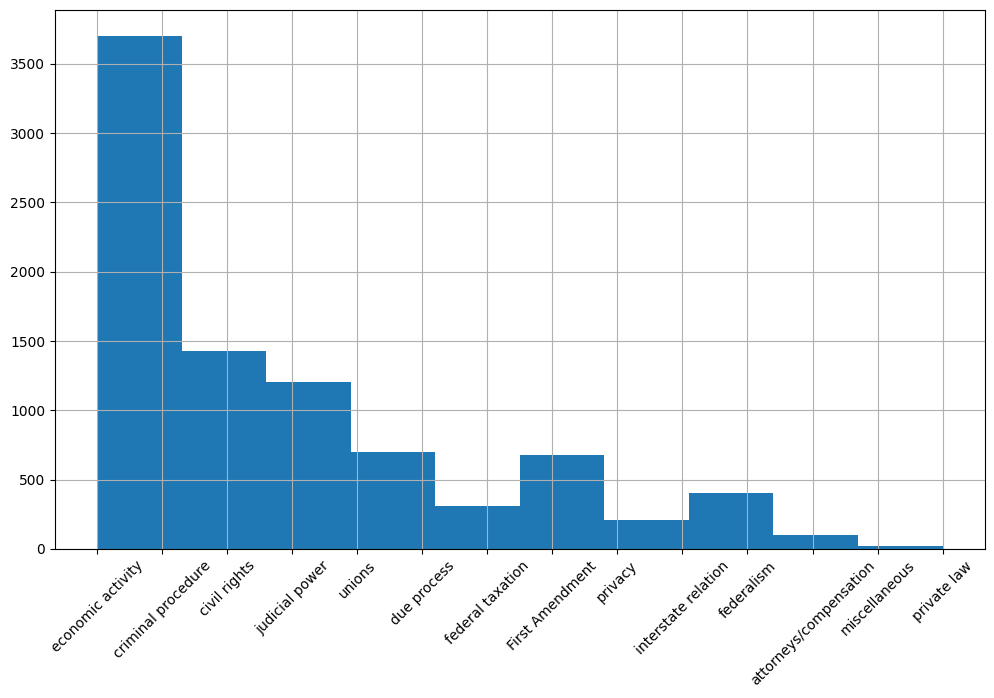

In [24]:
display(see_info['issueArea'].unique())
see_info['issueArea'].hist(xrot=45,figsize = (12,7))

#### Вывод:
Наибольшую долю дел составляют кейсы, связанные с экономической деятельностью, и криминальные дела, меньше всего дел в области частного права

In [11]:
see_info.head()

,term_docket,partyWinning,issue,issueArea
0,1946_24,1,80180,economic activity
1,1946_12,0,10500,criminal procedure
2,1946_21,0,80250,economic activity
3,1946_26,0,20150,civil rights
4,1946_50,1,80060,economic activity


Считаем и исследуем файл со скриптами выступлений:

In [25]:
df = pd.read_csv('cases.csv', sep='\t')
df['transcript_id'] = df['transcript_id'].str.replace('_t01','')
df['transcript_id'] = df['transcript_id'].str.replace('_t02','')
df  = df.join(see_info.set_index('term_docket'), on='transcript_id')

In [26]:
df = df.drop('Unnamed: 0.1', axis=1)
df = df.drop('Unnamed: 0', axis=1)

In [14]:
df.head(5)

,transcript_id,title,speaker,speaker_ID,speaker_role,speaker_appointing_pres,text_start,text_stop,text,text_duration,partyWinning,issue,issueArea
0,1989_89_386,Port Authority Trans-Hudson Corporation v. Feeney,William H. Rehnquist,15141.0,scotus_justice,Richard Nixon,0.000,15.926,We'll hear argument first this morning in No. ...,15.926,0,80060,economic activity
1,1989_89_386,Port Authority Trans-Hudson Corporation v. Feeney,Joseph Lesser,31462.0,not_a_justice,NaN,15.926,211.603,"Thank you, Mr. Chief Justice, and may it pleas...",195.677,0,80060,economic activity
2,1989_89_386,Port Authority Trans-Hudson Corporation v. Feeney,Antonin Scalia,15049.0,scotus_justice,Ronald Reagan,211.603,243.457,"Mr. Lesser, suppose a municipal corporation ha...",31.854,0,80060,economic activity
3,1989_89_386,Port Authority Trans-Hudson Corporation v. Feeney,Joseph Lesser,31462.0,not_a_justice,NaN,243.457,273.593,"--No, I don't think so. I think this question ...",30.136,0,80060,economic activity
4,1989_89_386,Port Authority Trans-Hudson Corporation v. Feeney,Antonin Scalia,15049.0,scotus_justice,Ronald Reagan,273.593,278.045,"Well, you... you... you say that... you say th...",4.452,0,80060,economic activity


Статистика продолжительности выступления по сферам судебных разбирательств:

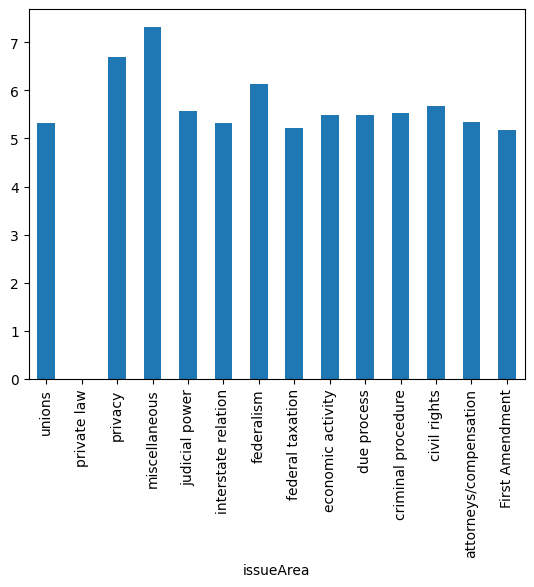

In [15]:
df.groupby('issueArea')['text_duration'].median().plot(rot=90, kind='bar').invert_xaxis()

#### Выводы:
Дольше всего в суде занимают выступления в категории "разнообразные" (те, которые не попадают ни в какую другую категорию). Следующими по долготе выступления являются дела, касающиеся конфиденциальности (privacy). Также большую длину имеют выступления по делам о федеральной власти (federalism). 

In [16]:
df_speaker=df.reset_index()

Все выступающие делятся на две категории: "судьи Верховного суда Сша" и "другие"(адвокаты, ответчики, истцы). Статистика выступлений по категориям участников суда: 

<AxesSubplot: ylabel='transcript_id'>

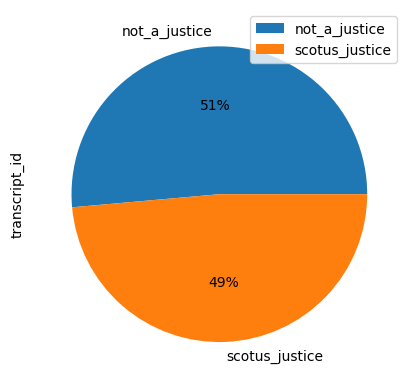

In [17]:
df_speaker.groupby(['speaker_role']).count().plot(kind='pie', y='transcript_id', autopct='%1.0f%%')

Выкачиваем дополнительную информацию по каждому делу: названия сторон; категории сторон; тип решения; сторона, одержавшая победу; адвокаты; судья
Категории сторон:
- Заявитель - лицо, которое подает петицию в суд, обычно в рамках апелляционного процесса, хотя иногда истец изначально может называться заявителем. Однако, если дело обжалуется, заявителем является лицо, проигравшее в суде низшей инстанции и передающее дело в суд вышестоящей инстанции.
- Ответчик - это лицо, против которого заявитель ведет спор. Тот, кто выиграл в суде низшей инстанции, как правило, является ответчиком, поскольку именно заявитель обжалует дело в вышестоящем суде. Иногда ответчик может называться ответчиком, даже если он не участвует в процессе обжалования.
- Апеллянт - это лицо, которое подает апелляцию из суда низшей инстанции в суд вышестоящей инстанции. По сути, они являются заявителями, но этот термин используется исключительно в апелляционном процессе.
- Апелли - это лицо, против которого подается апелляция из суда низшей инстанции в суд вышестоящей инстанции. По сути, они являются ответчиками, но этот термин (как и апеллянт) используется только в процессе обжалования.

In [18]:
sums = pd.read_csv('results.csv')

In [19]:
sums.head()

,Unnamed: 0,transcript_id,summary_id,term,case_name,lower_court,first_party,first_party_label,second_party,second_party_label,advocates,decision_type,winning_party,majority_vote,minority_vote,judge
0,0,OA1956_28,59387.0,1956,Rogers v. Missouri Pacific Railroad Company,NaN,Rogers,Petitioner,Missouri Pacific Railroad Company,Respondent,NaN,majority opinion,Rogers,6.0,2.0,"{u'John M. Harlan II': {u'vote': u'minority', ..."
1,1,OA1955_282,59216.0,1955,Schulz v. Pennsylvania Railroad Company,United States Court of Appeals for the Second ...,Schulz,Petitioner,Pennsylvania Railroad Company,Respondent,NaN,majority opinion,Schulz,5.0,3.0,"{u'John M. Harlan II': {u'vote': u'majority', ..."
2,2,OA1970_79,62137.0,1970,Connell v. Higginbotham,NaN,James Higginbotham,Appellant,Stella Connell,Appellee,"[(Sanford Jay Rosen, For the appellant), (Step...",per curiam,Connell,9.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major..."
3,3,OA1968_2,62286.0,1968,Red Lion Broadcasting Co. v. FCC,NaN,Red Lion Broadcasting Co.,Petitioner,Federal Communications Commission,Respondent,"[(Archibald Cox, for the respondents in US v. ...",majority opinion,Respondent,7.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major..."
4,4,OA1981_81_411,52485.0,1981,Jackson Transit Authority v. Local Division 12...,United States Court of Appeals for the Sixth C...,Jackson Transit Authority,Petitioner,"Local Division 1285, Amalgamated Transit Union...",Respondent,"[(Joseph S. Kaufman, on behalf of the Petition...",majority opinion,Jackson Transit Authority,9.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major..."


Составляем словарь адвокатов: 

In [109]:
counter=0
c_d = {} 
for i in sums.values:
    spis = i[10]
    counter+=1
    if not isinstance(spis, float):
        first_party = i[6]
        second_party = i[8]
        transcript_id = re.sub("OA", "", i[1])
        print(counter)
        spis =  re.sub('\[', '', spis)
        spis =  re.sub(' *\(', '', spis)
        spis =  re.sub('\)]', '', spis).split("),")   
        new_c_d = {}
        for i in spis:
            fio = i.split(", ")[0]
            if re.search("appellant|Appellant", i) or re.search("petitioner|Petitioner", i):
                role = "appellant/petitioner"
            elif re.search("appellee|Appellee", i) or re.search("respondent|Respondent", i):
                role = "appellee/respondent"
            
            elif not isinstance(first_party, float) and re.search(first_party, i):
                role = "appellant/petitioner"          
            elif not isinstance(second_party, float) and re.search(second_party, i):
                role = "appellee/respondent"        
            new_c_d[fio] = role
            c_d[transcript_id] = new_c_d

3
4
5
6
9
10
11
12
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
36
38
40
41
42
43
44
45
46
50
51
52
53
54
55
56
58
59
61
63
65
67
68
69
71
72
73
75
76
77
78
79
80
81
82
83
84
85
88
89
90
91
93
96
98
99
102
104
106
107
109
110
112
115
117
118
119
122
123
124
125
126
127
129
131
133
134
135
136
139
140
141
142
143
144
145
149
150
151
153
158
159
160
161
164
165
167
168
170
171
174
176
178
179
180
181
182
183
184
186
188
189
190
191
194
196
197
200
201
202
203
205
209
210
211
212
213
214
216
217
219
220
221
222
224
225
228
230
231
232
233
235
236
237
238
239
242
243
244
245
246
247
250
251
253
254
255
256
257
260
261
262
263
264
265
266
267
270
271
274
275
278
279
282
284
286
287
288
290
291
293
295
296
300
301
302
305
306
307
308
309
311
312
317
318
319
321
324
325
326
328
329
330
333
334
335
336
339
342
344
345
346
348
349
350
351
354
355
356
358
359
360
361
363
364
366
367
369
372
375
378
379
380
381
382
384
385
386
387
388
389
390
392
393
400
401
402
403
408
410
413
414
415
417


In [111]:
with open('advocates.json', 'w') as f:
    json.dump(c_d, f)

Далее для удобства итерации и нахождения нужной информации по делу запишем важную для статистики информацию в базу данных. База данных будет содержать три таблицы:
- Длительность выступления:
1. Идентификатор дела
2. Собственно длительность выступления
3. Область дела
- Сторона, выигравшая дело:
1. Идентификатор дела
2. Выигравшая сторона
- Скрипты выступлений
1. Идентификатор дела
2. Область дела
3. Текст (скрипт выступления)

In [334]:
import sqlite3
conn = sqlite3.connect('supreme.db')
cur = conn.cursor()

In [335]:
cur.execute("""
CREATE TABLE IF NOT EXISTS lenth
(id INTEGER PRIMARY KEY AUTOINCREMENT, transcript_id text, length float,  side text)
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS winner 
(id INTEGER PRIMARY KEY AUTOINCREMENT,transcript_id text, winner text) 
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS text 
(id INTEGER PRIMARY KEY AUTOINCREMENT,transcript_id text, issue text, speech text) 
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS advocates
(id INTEGER PRIMARY KEY AUTOINCREMENT,transcript_id text, name text, role text) 
""")

conn.commit()
conn.close()

Также для дальнейшей работы (создания моделей) определим в таблице с доп. информацией по делам категории победителей в разбирательствах: 1 сторона, 2 сторона, отсутствие вердикта

In [27]:
def winner(row):
    if row['winning_party'] == row['first_party']:
        val = row['first_party_label']
    elif row['winning_party'] == row['second_party']:
        val = row['second_party_label']
    else:
        val = 'No Verdict'
    return val

sums['winner'] = sums.apply(winner, axis=1)

In [126]:
def repl(row):
    val = str(row['transcript_id'])[2:]
    return val
sums['new_id']=sums.apply(repl, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562436 entries, 0 to 1557529
Data columns (total 13 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   transcript_id            1562436 non-null  object 
 1   title                    1556177 non-null  object 
 2   speaker                  1477816 non-null  object 
 3   speaker_ID               1477816 non-null  float64
 4   speaker_role             1477816 non-null  object 
 5   speaker_appointing_pres  708332 non-null   object 
 6   text_start               1562436 non-null  float64
 7   text_stop                1562436 non-null  float64
 8   text                     1562436 non-null  object 
 9   text_duration            817719 non-null   float64
 10  partyWinning             1496533 non-null  object 
 11  issue                    1496533 non-null  object 
 12  issueArea                1491268 non-null  object 
dtypes: float64(4), object(9)
memory usage: 199

In [338]:
conn = sqlite3.connect('supreme.db')
cur = conn.cursor()

Записываем нужные данные в таблицы бд:

In [330]:
for index, row in df.iterrows():
    cur.execute(
        """
        INSERT INTO lenth 
            (transcript_id, length, side)
            VALUES (?,?,?)
        """, ((row['transcript_id'], row['text_duration'], row['speaker_role'])))

In [331]:
for index, row in sums.iterrows():
    cur.execute(
        """
        INSERT INTO winner
            (transcript_id, winner)
            VALUES (?,?)
        """, ((row['transcript_id'], row['winner'])))

In [339]:
for index,row in df.iterrows():
    
    cur.execute(
        """
        INSERT INTO text 
            (transcript_id, issue, speech)
            VALUES (?,?,?)
        """, ((row['transcript_id'], row['issueArea'], row['text'])))

## Создание моделей

### Подготовка данных
Объединим таблицы с выступлениями и доп. информацией по делам по названиям дел. Далее для удобства обработки (если орбрабатывать данные частями, память не будет заполнена полностью) мы разбиваем данные на две части: выступления судей Верховного суда и выступления не судей. Значениями для классификации послужат выигравшие партии (стороны), соответственно, эти значения мы и будем предсказывать. Выборка делится в соотношении 2:1 (обучающая:тестовая), это кажется наилучшим решением при таком большом объеме данных ( (1562436 текстовых отрезков выступлений).

In [45]:
text_speaker = (df.pivot_table(index = 'title',columns = 'speaker_role', 
                                                     values = 'text',
                                                     aggfunc=lambda x: ' '.join(x))).reset_index()
count_vect = CountVectorizer()
data = text_speaker.join(sums.set_index('case_name')['winner'], on='title')
data = data[data.winner.notnull()]
data = data.dropna()
data = data[data['winner'] != 'No Verdict']
x = data[['not_a_justice', 'scotus_justice']]
y = data.winner
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)

### Тренировка модели с помощью CountVectorizer (предобработка данных для предсказания) и Логистической регресии (непосредственно тренировка модели и получение предсказаний)
Предобрабатываем тексты с помощью CountVectorizer (создаем численные матрицы токенов) и, т.к. датасеты занимают значительную часть памяти, сохраняем полученные матрицы в csv файлы, а сами матричные датасеты удаляем. 

In [ ]:
count_vect = CountVectorizer()
train_not_a_justice = count_vect.fit(x_train['not_a_justice'])
train_scotus_justice = count_vect.fit(x_train['scotus_justice'])
test_not_a_justice = count_vect.fit(x_test['not_a_justice'])
test_scotus_justice = count_vect.fit(x_test['scotus_justice'])

train_not_a_justice = pd.DataFrame(train_not_a_justice.transform(x_train['not_a_justice']).todense(),
                                        columns = train_not_a_justice.get_feature_names())
train_scotus_justice = pd.DataFrame(train_scotus_justice.transform(x_train['scotus_justice']).todense(),
                                        columns = train_scotus_justice.get_feature_names())
test_not_a_justice = pd.DataFrame(test_not_a_justice.transform(x_test['not_a_justice']).todense(),
                                        columns = test_not_a_justice.get_feature_names())
test_scotus_justice = pd.DataFrame(test_scotus_justice.transform(x_test['scotus_justice']).todense(),
                                        columns = test_scotus_justice.get_feature_names())
x_train = pd.concat([train_not_a_justice, train_scotus_justice], axis = 1)
x_test = pd.concat([test_not_a_justice, test_scotus_justice], axis = 1)
x_train.to_csv('train_x')
x_test.to_csv('test_x')
y_train.to_csv('train_y')
y_test.to_csv('test_y')

В дальнейшем при тренировке модели мы каждый раз будем считывать датасеты матриц из csv-файлов

In [3]:
x_train = pd.read_csv('train_x')
x_test = pd.read_csv('test_x')
y_train = pd.read_csv('train_y')
y_test = pd.read_csv('test_y')

In [ ]:
del x_train
del x_test
del y_train
del y_test

Тренируем модель с помощью логистической регрессии, все параметры оставляем с дефолтными значениями:

In [7]:
lr_model = LogisticRegression(C = 1, penalty = "l2")
lr_model_train = lr_model.fit(x_train, y_train['vedict'])
lr_prediction = lr_model.predict(x_test)
lr_accuracy = np.mean(lr_prediction == y_test['verdict'])
print('Точность по CV и Логистической регрессии:', round(lr_accuracy,3))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность по CV и Логистической регрессии: 0.876


In [41]:
del sums

In [29]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer

Теперь при получении токенов будем также использовать лемматизацию из nltk, напишем функцию, которая сначала лемматизирует, а потом токенизирует текст, передадим ее в качестве токенизатора в CountVectorizer

In [31]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [33]:
count_vect = CountVectorizer(tokenizer=LemmaTokenizer())
train_not_a_justice = count_vect.fit(x_train['not_a_justice'])
train_scotus_justice = count_vect.fit(x_train['scotus_justice'])
test_not_a_justice = count_vect.fit(x_test['not_a_justice'])
test_scotus_justice = count_vect.fit(x_test['scotus_justice'])

train_not_a_justice = pd.DataFrame(train_not_a_justice.transform(x_train['not_a_justice']).todense(),
                                        columns = train_not_a_justice.get_feature_names())
train_scotus_justice = pd.DataFrame(train_scotus_justice.transform(x_train['scotus_justice']).todense(),
                                        columns = train_scotus_justice.get_feature_names())
test_not_a_justice = pd.DataFrame(test_not_a_justice.transform(x_test['not_a_justice']).todense(),
                                        columns = test_not_a_justice.get_feature_names())
test_scotus_justice = pd.DataFrame(test_scotus_justice.transform(x_test['scotus_justice']).todense(),
                                        columns = test_scotus_justice.get_feature_names())

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python31

In [34]:
x_train = pd.concat([train_not_a_justice, train_scotus_justice], axis = 1)
x_test = pd.concat([test_not_a_justice, test_scotus_justice], axis = 1)
x_train.to_csv('train_nltk_x')
x_test.to_csv('test_nltk_x')

In [40]:
lr_model = LogisticRegression(C = 1, penalty = "l2")
lr_model_train = lr_model.fit(x_train, y_train)
lr_prediction = lr_model.predict(x_test)
lr_accuracy = np.mean(lr_prediction == y_test)
print('Точность по CV и Логистической регрессии:', round(lr_accuracy,3))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность по CV и Логистической регрессии: 0.872


#### Выводы: 
Можно заметить, что с тем же набором параметров модель, для тенировки которой использовались лемматизированные данные, дала точность на 0.004 меньше, но это незначительное отличие. 

In [41]:
del x_train
del x_test
del y_train
del y_test

In [44]:
#del train_not_a_justice, train_scotus_justice
del test_not_a_justice, test_scotus_justice

### Тренировка модели с помощью TfidfVectorizer (предобработка данных для предсказания) и Логистической регресии (непосредственно тренировка модели и получение предсказаний)

Tfidf извлекает триграммы, так как для насс значение имеют не конкретные слова, а контекс, при этом, если брать н-граммы с большим значением (4,5 и т.д.) может потеряться вес отдельных фраз, которые имеют высокую частотность при выигрыше/проигрыше. В дальнейшем мы проанализируем самые частотные триграммы и, в противовес, 1-граммы при выигрыше тех или иных сторон. В качестве значения максимального значения признаков берем первые 2500, так как это значение кажется нам разумным в отношении абсолютного числа текстов.

In [47]:
count_vect = TfidfVectorizer(ngram_range = (3,3), max_features = 2500,  lowercase = False)
train_not_a_justice = count_vect.fit(x_train['not_a_justice'])
train_scotus_justice = count_vect.fit(x_train['scotus_justice'])
test_not_a_justice = count_vect.fit(x_test['not_a_justice'])
test_scotus_justice = count_vect.fit(x_test['scotus_justice'])

train_not_a_justice = pd.DataFrame(train_not_a_justice.transform(x_train['not_a_justice']).todense(),
                                        columns = train_not_a_justice.get_feature_names())
train_scotus_justice = pd.DataFrame(train_scotus_justice.transform(x_train['scotus_justice']).todense(),
                                        columns = train_scotus_justice.get_feature_names())
test_not_a_justice = pd.DataFrame(test_not_a_justice.transform(x_test['not_a_justice']).todense(),
                                        columns = test_not_a_justice.get_feature_names())
test_scotus_justice = pd.DataFrame(test_scotus_justice.transform(x_test['scotus_justice']).todense(),
                                        columns = test_scotus_justice.get_feature_names())

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\AppData\Local\Programs\Python\Python31

In [48]:
x_train = pd.concat([train_not_a_justice, train_scotus_justice], axis = 1)
x_test = pd.concat([test_not_a_justice, test_scotus_justice], axis = 1)
x_train.to_csv('train_tfidf_x')
x_test.to_csv('test_tfidf_x')

In [226]:
x_train = pd.read_csv('train_tfidf_x')
x_test = pd.read_csv('test_tfidf_x')

In [227]:
del y_train, y_test

In [228]:
y_train = pd.read_csv('train_y')
y_test = pd.read_csv('test_y')

In [230]:
y_train

,Unnamed: 0,verdict
0,155,Petitioner
1,1564,Appellant
2,4136,Petitioner
3,1811,Petitioner
4,1868,Petitioner
...,...,...
1969,3649,Petitioner
1970,197,Appellant
1971,3485,Petitioner
1972,2683,Petitioner


In [231]:
svc_model = LinearSVC(C=0.88)
svc_model.fit(x_train, y_train['verdict'])
preds = svc_model.predict(x_test)
accuracy = (preds== y_test['verdict']).mean()
print('Точность по tfidf и LinearSVC:', round(lr_accuracy,3))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Точность по tfidf и LinearSVC: 0.872


In [232]:
svc_model = LinearSVC(C=1)
svc_model.fit(x_train, y_train['verdict'])
preds = svc_model.predict(x_test)
accuracy = (preds== y_test['verdict']).mean()
print('Точность по tfidf и LinearSVC:', round(lr_accuracy,3))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Точность по tfidf и LinearSVC: 0.872


In [233]:
svc_model = LinearSVC(C=0.86)
svc_model.fit(x_train, y_train['verdict'])
preds = svc_model.predict(x_test)
accuracy = (preds== y_test['verdict']).mean()
print('Точность по tfidf и LinearSVC:', round(lr_accuracy,3))

Точность по tfidf и LinearSVC: 0.872


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Анализ самых частотных словосочетаний при выигрыше

In [61]:
x_train

,All right Now,All right So,And do you,And if it,And if that,And if the,And if they,And if you,And it seems,And it was,...,your argument that,your brief that,your point is,your point of,your position is,your position on,your position that,your response to,your view of,your view that
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0
1,0.000000,0.0,0.0,0.000000,0.008175,0.030421,0.016094,0.020463,0.037081,0.056045,...,0.000000,0.033403,0.00000,0.00000,0.023772,0.0,0.044317,0.00000,0.054679,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.023866,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.04332,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023955,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0
4,0.000000,0.0,0.0,0.043765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.044580,0.0,0.000000,0.00000,0.000000,0.0
1970,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.05933,0.00000,0.000000,0.0,0.041933,0.00000,0.000000,0.0
1971,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0
1972,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0


In [64]:
y_tr = pd.DataFrame(y_train)
y_tr.reset_index()

,index,winner
0,3551,Petitioner
1,3770,Petitioner
2,754,Petitioner
3,3063,Petitioner
4,250,Petitioner
...,...,...
1969,807,Petitioner
1970,4122,Petitioner
1971,2092,Petitioner
1972,1792,Petitioner


Совмещаем таблицы с векторами и выигравшей стороной

In [67]:
analyze = pd.concat([x_train, y_tr.reset_index()], axis = 1)

In [69]:
analyze

,All right Now,All right So,And do you,And if it,And if that,And if the,And if they,And if you,And it seems,And it was,...,your point is,your point of,your position is,your position on,your position that,your response to,your view of,your view that,index,winner
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,3551,Petitioner
1,0.000000,0.0,0.0,0.000000,0.008175,0.030421,0.016094,0.020463,0.037081,0.056045,...,0.00000,0.00000,0.023772,0.0,0.044317,0.00000,0.054679,0.0,3770,Petitioner
2,0.000000,0.0,0.0,0.000000,0.000000,0.023866,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.04332,0.000000,0.0,754,Petitioner
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,3063,Petitioner
4,0.000000,0.0,0.0,0.043765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,250,Petitioner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.044580,0.0,0.000000,0.00000,0.000000,0.0,807,Petitioner
1970,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.05933,0.00000,0.000000,0.0,0.041933,0.00000,0.000000,0.0,4122,Petitioner
1971,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,2092,Petitioner
1972,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,1792,Petitioner


In [93]:
winner = analyze.iloc[:, :7500]

Подсчитываем количество использований каждой триграммы (столбцы) в каждой речи (строки)

In [94]:
winner = winner.append(winner.apply(np.count_nonzero, axis = 0), ignore_index = True)

C:\Users\User\AppData\Local\Temp\ipykernel_15376\72291437.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winner = winner.append(winner.apply(np.count_nonzero, axis = 0), ignore_index = True)


In [101]:
winner

,All right Now,All right So,And do you,And if it,And if that,And if the,And if they,And if you,And it seems,And it was,...,your point is,your point of,your position is,your position on,your position that,your response to,your view of,your view that,index,winner
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,3551,Petitioner
1,0.000000,0.0,0.0,0.000000,0.008175,0.030421,0.016094,0.020463,0.037081,0.056045,...,0.00000,0.00000,0.023772,0.0,0.044317,0.00000,0.054679,0.0,3770,Petitioner
2,0.000000,0.0,0.0,0.000000,0.000000,0.023866,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.04332,0.000000,0.0,754,Petitioner
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,3063,Petitioner
4,0.000000,0.0,0.0,0.043765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,250,Petitioner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.05933,0.00000,0.000000,0.0,0.041933,0.00000,0.000000,0.0,4122,Petitioner
1971,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,2092,Petitioner
1972,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,1792,Petitioner
1973,0.003343,0.0,0.0,0.000000,0.000000,0.001634,0.006917,0.010260,0.001594,0.006882,...,0.00000,0.03556,0.000000,0.0,0.000000,0.00000,0.014233,0.0,4568,Petitioner


In [116]:
winner['winner'].unique()

array(['Petitioner', 'Appellant', 'Respondent', 'Appellee', 1974],
      dtype=object)

#### Полученная статистика

In [115]:
print('Топ 100 триграмм, использованных при выступлениях:')
print(winner.loc[1974].sort_values(ascending = False)[2:102])

Топ 100 триграмм, использованных при выступлениях:
in this case        1933.0
the fact that       1701.0
there is no         1632.0
is that the         1613.0
one of the          1606.0
                     ...  
believe that the     945.0
the fact that        941.0
and this is          934.0
you have to          931.0
Thank you Mr         927.0
Name: 1974, Length: 100, dtype: object


##### Топ 100 триграмм, использованных при выигрыше Апеллянта

In [140]:
print(pd.DataFrame(winner.loc[(winner['winner'].isin(['Appellant',1974]))]).loc[1974].sort_values(ascending = False)[2:102])
#df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]

in this case        1933.0
the fact that       1701.0
there is no         1632.0
is that the         1613.0
one of the          1606.0
                     ...  
believe that the     945.0
the fact that        941.0
and this is          934.0
you have to          931.0
Thank you Mr         927.0
Name: 1974, Length: 100, dtype: object


##### Топ 100 триграмм, использованных при выигрыше заявителя

In [141]:
print(pd.DataFrame(winner.loc[(winner['winner'].isin(['Petitioner',1974]))]).loc[1974].sort_values(ascending = False)[2:102])
#df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]

in this case        1933.0
the fact that       1701.0
there is no         1632.0
is that the         1613.0
one of the          1606.0
                     ...  
believe that the     945.0
the fact that        941.0
and this is          934.0
you have to          931.0
Thank you Mr         927.0
Name: 1974, Length: 100, dtype: object


##### Топ 100 триграмм, использованных при выигрыше Ответчика

In [142]:
print(pd.DataFrame(winner.loc[(winner['winner'].isin(['Respondent',1974]))]).loc[1974].sort_values(ascending = False)[2:102])

in this case        1933.0
the fact that       1701.0
there is no         1632.0
is that the         1613.0
one of the          1606.0
                     ...  
believe that the     945.0
the fact that        941.0
and this is          934.0
you have to          931.0
Thank you Mr         927.0
Name: 1974, Length: 100, dtype: object


##### Топ 100 триграмм, использованных при выигрыше Аппелли

In [143]:
print(pd.DataFrame(winner.loc[(winner['winner'].isin(['Appellee',1974]))]).loc[1974].sort_values(ascending = False)[2:102])

in this case        1933.0
the fact that       1701.0
there is no         1632.0
is that the         1613.0
one of the          1606.0
                     ...  
believe that the     945.0
the fact that        941.0
and this is          934.0
you have to          931.0
Thank you Mr         927.0
Name: 1974, Length: 100, dtype: object


### Выводы:
В зависимости от того, кто выигрывает дело, частотность фраз не меняется

In [146]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 153.1/153.1 kB 2.3 MB/s eta 0:00:00


### Создание облаков n-грамм и слов по частности

In [151]:
freq = (winner.loc[1974].sort_values(ascending = False)[2:102]).to_dict()

In [153]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').fit_words(freq)

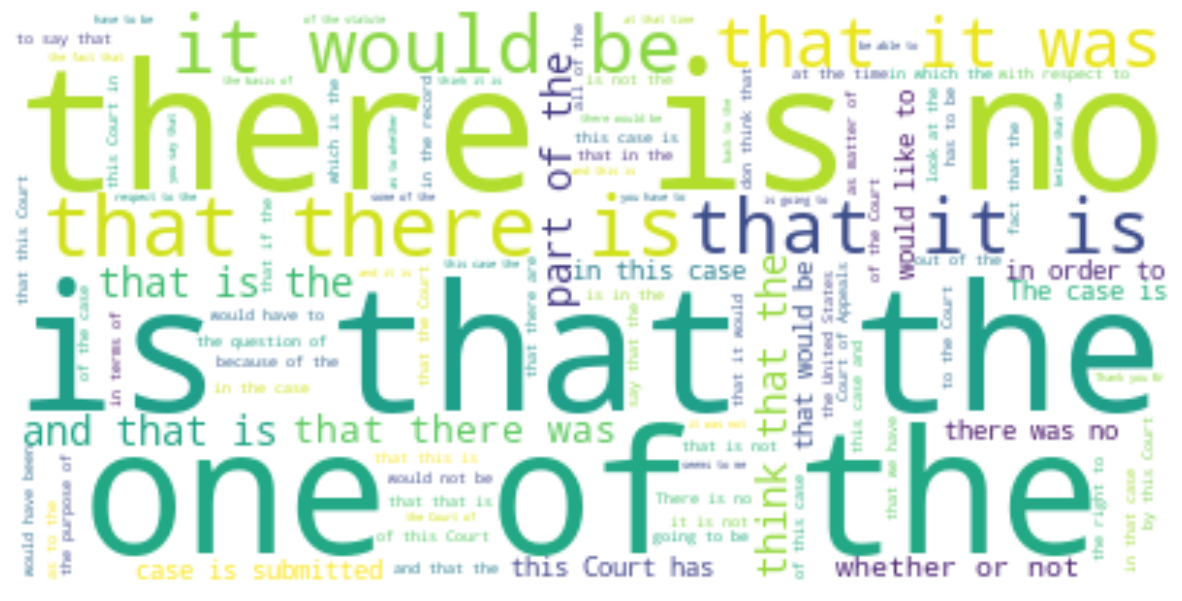

In [156]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

In [157]:
del x_train
del x_test
del analyze
del winner

In [159]:
x_train = pd.read_csv('train_nltk_x')
x_test = pd.read_csv('test_nltk_x')

In [174]:
del y_tr

In [161]:
analyze = x_train.append(x_train.apply(np.count_nonzero, axis = 0), ignore_index = True)

C:\Users\User\AppData\Local\Temp\ipykernel_15376\2755305432.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analyze = x_train.append(x_train.apply(np.count_nonzero, axis = 0), ignore_index = True)


In [162]:
analyze

,Unnamed: 0,!,#,$,%,&,','','06,'20s,...,–.1,–-.1,–-about.1,—.1,‘.1,’.1,“.1,”.1,″.1,‶.1
0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,67,0,0,0,0
2,2,0,0,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,2,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,0,26,1,0,4,1,0,0,...,0,0,0,0,0,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,1970,0,0,0,1,0,0,0,0,0,...,0,0,0,0,4,0,8,7,0,0
1971,1971,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,1972,0,0,5,0,0,3,0,0,0,...,0,0,0,0,1,0,3,3,0,0
1973,1973,0,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,9,6,0,0


In [163]:
freq = (analyze.loc[1974].sort_values(ascending = False)[2:102]).to_dict()

In [164]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').fit_words(freq)

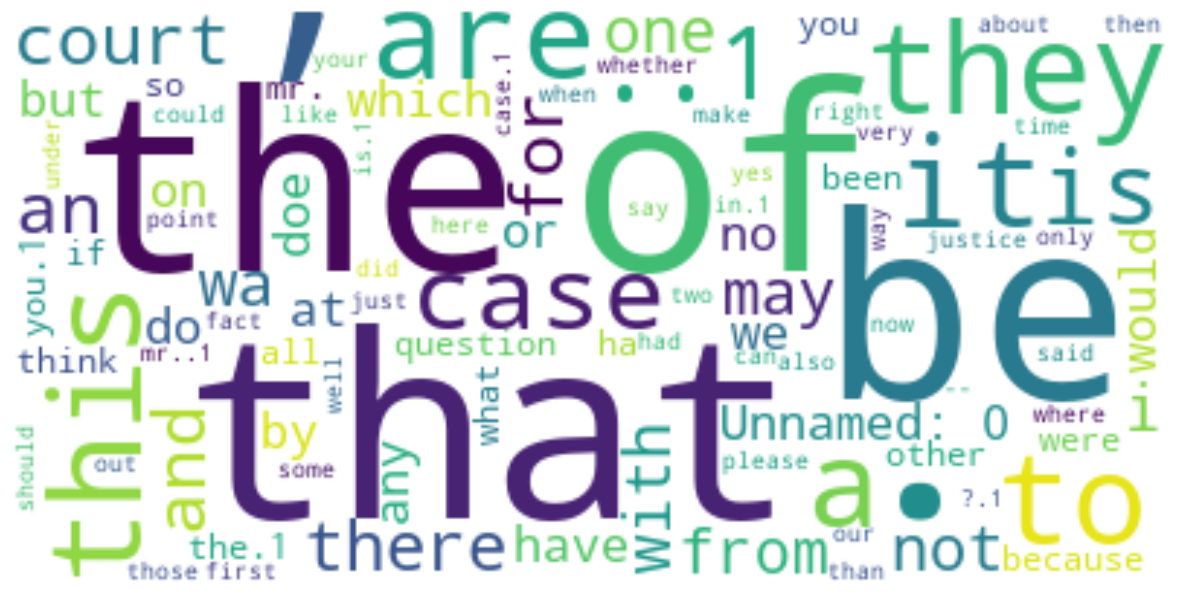

In [165]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

Так как мы не удаляли стоп-слова для лучшего выступления моделей, они являются самыми частотными, что можно заметить на изображениях облаков слов

In [175]:
del train_not_a_justice, train_scotus_justice, test_not_a_justice, test_scotus_justice

In [177]:
sums

,Unnamed: 0,transcript_id,summary_id,term,case_name,lower_court,first_party,first_party_label,second_party,second_party_label,advocates,decision_type,winning_party,majority_vote,minority_vote,judge,winner
0,0,OA1956_28,59387.0,1956,Rogers v. Missouri Pacific Railroad Company,NaN,Rogers,Petitioner,Missouri Pacific Railroad Company,Respondent,NaN,majority opinion,Rogers,6.0,2.0,"{u'John M. Harlan II': {u'vote': u'minority', ...",Petitioner
1,1,OA1955_282,59216.0,1955,Schulz v. Pennsylvania Railroad Company,United States Court of Appeals for the Second ...,Schulz,Petitioner,Pennsylvania Railroad Company,Respondent,NaN,majority opinion,Schulz,5.0,3.0,"{u'John M. Harlan II': {u'vote': u'majority', ...",Petitioner
2,2,OA1970_79,62137.0,1970,Connell v. Higginbotham,NaN,James Higginbotham,Appellant,Stella Connell,Appellee,"[(Sanford Jay Rosen, For the appellant), (Step...",per curiam,Connell,9.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major...",No Verdict
3,3,OA1968_2,62286.0,1968,Red Lion Broadcasting Co. v. FCC,NaN,Red Lion Broadcasting Co.,Petitioner,Federal Communications Commission,Respondent,"[(Archibald Cox, for the respondents in US v. ...",majority opinion,Respondent,7.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major...",No Verdict
4,4,OA1981_81_411,52485.0,1981,Jackson Transit Authority v. Local Division 12...,United States Court of Appeals for the Sixth C...,Jackson Transit Authority,Petitioner,"Local Division 1285, Amalgamated Transit Union...",Respondent,"[(Joseph S. Kaufman, on behalf of the Petition...",majority opinion,Jackson Transit Authority,9.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major...",Petitioner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7894,7894,OA2016_15_797,62716.0,2016,Moore v. Texas,Texas Court of Criminal Appeals,Bobby James Moore,Petitioner,Texas,Respondent,"[(Clifford M. Sloan, for petitioner), (Scott A...",majority opinion,Moore,5.0,3.0,"{u'Stephen G. Breyer': {u'vote': u'majority', ...",No Verdict
7895,7895,OA1940_1955_320us81,62498.0,1940-1955,Hirabayashi v. United States,NaN,Hirabayashi,Petitioner,United States,Respondent,NaN,NaN,NaN,NaN,NaN,NaN,No Verdict
7896,7896,OA1973_73_797,51114.0,1973,Miami Herald Publishing Company v. Tornillo,Florida Supreme Court,Miami Herald Publishing Company,Appellant,Pat Tornillo,Appellee,"[(Daniel P. S. Paul, argued the cause for the ...",majority opinion,Miami Herald Publishing Company,9.0,0.0,"{u'William J. Brennan, Jr.': {u'vote': u'major...",Appellant
7897,7897,OA1999_8_orig,54843.0,1999,Arizona v. California,NaN,Arizona,Petitioner,California,Respondent,"[(Jeffrey P. Minear, Department of Justice, ar...",majority opinion,Arizona,6.0,3.0,"{u'Clarence Thomas': {u'vote': u'minority', u'...",Petitioner


## Предсказание с помощью сверточных нейронных сетей (CNN) в Keras и долгой краткосрочной памяти (LSTM) с использованием токенизации и лемматизации nltk

In [178]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [223]:
import gc
gc.collect() #очистка памяти

12994

In [180]:
text_speaker = (df.pivot_table(index = 'title',columns = 'speaker_role', 
                                                     values = 'text',
                                                     aggfunc=lambda x: ' '.join(x))).reset_index()
data = text_speaker.join(sums.set_index('case_name')['winner'], on='title')
data = data[data.winner.notnull()]
data = data.dropna()
data = data[data['winner'] != 'No Verdict']

In [186]:
data

,title,not_a_justice,scotus_justice,winner
0,324 Liquor Corporation v. Duffy,"Mr. Chief Justice, and may it please the Court...",We will hear arguments first this afternoon in...,Appellant
1,44 Liquormart Inc. v. Rhode Island,Mr. Chief Justice and may it please the Court-...,We'll hear argument first this morning in Numb...,Petitioner
2,"A Book Named ""John Cleland's Memoirs of a Woma...",I had Your Honor. I would like to save the rem...,"-- of Pleasure”, Appellant, versus Attorney Ge...",Appellant
3,"A. L. Mechling Barge Lines, Inc. v. United States",May I should like to call attention to the rep...,"May, I ask you please, is this matter in conte...",Appellant
3,"A. L. Mechling Barge Lines, Inc. v. United States",May I should like to call attention to the rep...,"May, I ask you please, is this matter in conte...",Appellant
...,...,...,...,...
5099,Zivotofsky v. Clinton,"Mr. -- Mr. Chief Justice, and may it please th...",We'll hear argument first this morning in Case...,Petitioner
5100,Zobel v. Williams,"Thank you. Mr. Chief Justice, and may it pleas...",We'll hear arguments first this morning in Zob...,Appellant
5101,Zobrest v. Catalina Foothills School District,"Chief Justice Rehnquist, may it please the Cou...","We'll hear argument next in No. 92-94, Larry Z...",Petitioner
5102,Zschernig v. Miller,"Mr. Chief Justice, may it please the Court. Th...","Number 21, Oswald Zschernig et al., appellants...",Appellant


In [187]:
data.winner.unique()

array(['Appellant', 'Petitioner', 'Respondent', 'Appellee'], dtype=object)

In [185]:
#del text_speaker
#del df
del sums

In [188]:
data['ver_type'] = data['winner'].map({'Appellant':0, 'Petitioner':1,'Respondent':2, 'Appellee':3})
y = data['ver_type'].values
data.head()

,title,not_a_justice,scotus_justice,winner,ver_type
0,324 Liquor Corporation v. Duffy,"Mr. Chief Justice, and may it please the Court...",We will hear arguments first this afternoon in...,Appellant,0
1,44 Liquormart Inc. v. Rhode Island,Mr. Chief Justice and may it please the Court-...,We'll hear argument first this morning in Numb...,Petitioner,1
2,"A Book Named ""John Cleland's Memoirs of a Woma...",I had Your Honor. I would like to save the rem...,"-- of Pleasure”, Appellant, versus Attorney Ge...",Appellant,0
3,"A. L. Mechling Barge Lines, Inc. v. United States",May I should like to call attention to the rep...,"May, I ask you please, is this matter in conte...",Appellant,0
3,"A. L. Mechling Barge Lines, Inc. v. United States",May I should like to call attention to the rep...,"May, I ask you please, is this matter in conte...",Appellant,0


В этот раз мы усложнили задачу, используя для предсказания только выступления тех участников судебного заседания, которые не являются непосредственными судьями Верховного суда:

In [189]:
x_train, x_test, y_train, y_test = train_test_split(data['not_a_justice'], y, test_size=0.2, random_state=434)

In [190]:
del y

### Предобработка 
Размер словаря (500) определяется таким образом, чтобы слова, относящиеся к отдельным подробностям каждого дела в него не попадали, а использовались только те фразы, которые так или иначе влияет на выигрыш или проигрыш стороны. Параметр oov_token определяет, каким образом (чем) будут заменены слова не попавшие в словарь. Параметр char_level влияет на то, будут ли все символы рассмотрены как токены, в нашем случае пунктуация не нужна, поэтому параметр принимает значение False. 

После токенизации мы переходим к этапу обработки последовательностей. Этот этапа необходим, чтобы загрузить обучающие данные в Последовательную модель (Sequential model). Функция  pad_sequences возвращает двухмерный массив, размер которого определяется двумя величинами: количеством векторов и длиной каждой последовательности (50 в данном случае). Максимальная длина последовательности составляет 50, так как, скорее всего, это относительно наибольший размер, который может иметь фраза при выступлении. Параметр truncating определяет, какая часть фразы будет урезана по достижении макссимальной длины (50). Он принимает значение 'post', так как, скорее всего, аргумент в речи будет находиться в начале, а в дальнейшем будут следовать объяснения, если фразовый отрезок достаточно большой. Параметр padding определяет, где будут расположены отступы между последовательностями: до или после них, в данном случае принимает значение "после". 

In [191]:
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [192]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [193]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

65885

In [194]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [196]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [197]:
#del x_train
del x_test

In [198]:
print('Размер тензора для обучения: ', training_padded.shape)
print('Размер тензора для тестирования: ', testing_padded.shape)

Размер тензора для обучения:  (2357, 50)
Размер тензора для тестирования:  (590, 50)


### Создание первой модели 
- Уровень Эмбеддингов

Параметр, отвечающий за размер словаря, остается неизменным. Переменная embedding_dim передается в параметр output_dim и отвечает за размеры эмбеддингов. В нашем случае их будет очень много в соответствии с тензорами для обучения и тестирования, поэтому размер каждого эмбеддинга не должен быть слишком большим. Длина последовательностей остается такой же, как при создании отступов между последовательностями. 
- Уровень дропаута

Параметр rate отвечает за долю инпута, которую не нужно учитывать при тренировке модели. Так как данных много, в данном случае он принимает значение 0.2 (20%). 
- Уровень пулинга

Используется для того, чтобы равномерно распределить "внимание" модели при обработке признаков, так как сверточные уровни могут увеличивать вес одних признаков и уменьшать вес других. Функция GlobalAveragePooling1D()) предотвращает модель от недо- и переобучения. 
- Уровень плотности

Определяется дважды в зависимости от используемой функции активации модели. Функция активации определяет функцию приближения предсказанных значений к реальным. В первом случае это  выпрямленная линейная функция активации (rectified linear unit, ReLU). Во втором - сигмоидная функция.Преимуществом линейной над сигмоидной является отсутствие затухания градиентов (это происходит на краях сигмоидной функции в местах, где значения по ординате стремятся к 0 и 1). Это же свойство является преимуществом сигмоидной функции над выпрямленной, так как подвергается простой интерпретации за счет насыщения градиентов по краям. Из-за простоты линейной функции плотность линейного пространства для нее должна иметь большее значение, чем в случае с сигмоидной функцией (первый аргумент уровня плотности)

In [199]:
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

При подсчете ошибок (потерь) при компиляции модели используется бинарная функция кросс-энтропии (логарифмической функции потерь), так как имеется два класса: выигрыш и проигрыш, разбитые по группам сторон (заявитель, ответчик и т.д.). Оптимизатор принимает функцию, обновляющую веса нейросети. Если признаки типичны и не нужно быстрого обновления весов, выбирается один из самых простейших алгоритмов - 'adam'. В качестве метрики нас интересует точность предсказаний.

Параметр callbacks отвечает за обратные вызовы модели, в данном случае в него передана функция, которая останавливает работу модели после отсутствия повышения точности на протяжении трех итераций подряд. Параметр verbose отвечает за протокол обучения модели. При значении 2 это одна строка в одну итерацию. 

In [200]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [201]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
74/74 - 5s - loss: 0.5987 - accuracy: 0.8167 - val_loss: 0.4837 - val_accuracy: 0.8220 - 5s/epoch - 71ms/step
Epoch 2/30
74/74 - 1s - loss: 0.4288 - accuracy: 0.8197 - val_loss: 0.4039 - val_accuracy: 0.8220 - 1s/epoch - 14ms/step
Epoch 3/30
74/74 - 1s - loss: 0.4075 - accuracy: 0.8197 - val_loss: 0.3968 - val_accuracy: 0.8220 - 1s/epoch - 14ms/step
Epoch 4/30
74/74 - 1s - loss: 0.3987 - accuracy: 0.8197 - val_loss: 0.3895 - val_accuracy: 0.8220 - 849ms/epoch - 11ms/step
Epoch 5/30
74/74 - 1s - loss: 0.3867 - accuracy: 0.8197 - val_loss: 0.3807 - val_accuracy: 0.8220 - 844ms/epoch - 11ms/step
Epoch 6/30
74/74 - 1s - loss: 0.3748 - accuracy: 0.8197 - val_loss: 0.3712 - val_accuracy: 0.8220 - 651ms/epoch - 9ms/step
Epoch 7/30
74/74 - 1s - loss: 0.3592 - accuracy: 0.8197 - val_loss: 0.3582 - val_accuracy: 0.8220 - 645ms/epoch - 9ms/step
Epoch 8/30
74/74 - 1s - loss: 0.3388 - accuracy: 0.8214 - val_loss: 0.3382 - val_accuracy: 0.8254 - 665ms/epoch - 9ms/step
Epoch 9/30
74/74 - 1

In [202]:
model.evaluate(testing_padded, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.2800 - accuracy: 0.8695


[0.280004620552063, 0.8694915175437927]

In [204]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

### Создание второй модели 
Отличие от первой модели заключается в добавлении уровня долгой краткосрочной памяти, сверточного слоя и в отличии количества отбрасываемых значений (50%)
- Уровень долгой краткосрочной памяти 

Параметр return_sequences принимает значение True (для уменьшения занимаемой моделью памяти) и отвечает за то, возвращать ли последнюю последовательность из набора или все. 
- Сверточный слой

Сверточные слои отвечают за формирование и передачу матриц вместе с субдискретизирующими слоями. Каждый сверточный слой представляет из себя набор матриц, чем их больше, тем выше точность, при этом увеличивается время обработки входных данных. В данном случае количество фильтров равно 100, при таком значении точность примерно так же высока, как для моделей, обученных на всех данных (а не только скриптах выступлений не судей Верховного суда), и при этом время обучения не слишком высоко (около 7 минут). Размер окна (kernel_size) равен 4, так как при повышении значения уменьшается точность (происходит переобучение модели). Паддинг отвечает за соотношение размеров входных и выходных данных, в нашем случае размеры одинаковые, этот параметр важен при обработке изображений, но не текстовых данных. 

In [214]:
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.Conv1D(filters=100,kernel_size=4,
    padding="same",
    activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [215]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adamax', metrics= ['accuracy'])

In [216]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           46800     
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 100)           40100     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 100)          0         
 1D)                                                             
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                             

In [217]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
74/74 - 30s - loss: 0.4785 - accuracy: 0.8133 - val_loss: 0.4515 - val_accuracy: 0.8220 - 30s/epoch - 412ms/step
Epoch 2/30
74/74 - 25s - loss: 0.4094 - accuracy: 0.8197 - val_loss: 0.4358 - val_accuracy: 0.8220 - 25s/epoch - 331ms/step
Epoch 3/30
74/74 - 31s - loss: 0.3987 - accuracy: 0.8197 - val_loss: 0.4050 - val_accuracy: 0.8220 - 31s/epoch - 419ms/step
Epoch 4/30
74/74 - 33s - loss: 0.3678 - accuracy: 0.8197 - val_loss: 0.3863 - val_accuracy: 0.8220 - 33s/epoch - 448ms/step
Epoch 5/30
74/74 - 21s - loss: 0.3158 - accuracy: 0.8434 - val_loss: 0.3148 - val_accuracy: 0.8610 - 21s/epoch - 283ms/step
Epoch 6/30
74/74 - 19s - loss: 0.2528 - accuracy: 0.8647 - val_loss: 0.2972 - val_accuracy: 0.8644 - 19s/epoch - 258ms/step
Epoch 7/30
74/74 - 21s - loss: 0.2383 - accuracy: 0.8706 - val_loss: 0.2914 - val_accuracy: 0.8610 - 21s/epoch - 280ms/step
Epoch 8/30
74/74 - 29s - loss: 0.2209 - accuracy: 0.8727 - val_loss: 0.2886 - val_accuracy: 0.8627 - 29s/epoch - 390ms/step
Epoch 9/

In [218]:
model.evaluate(testing_padded, y_test)

19/19 [==============================] - 2s 96ms/step - loss: 0.3629 - accuracy: 0.8610


[0.3628937005996704, 0.8610169291496277]

## Выводы
Для предобработки данных были применены токенизация nltk, tfidf, лемматизация nltk, токенизация keras. Для тренировки моделей были использованы логистическая регрессия, Linear SVC, долгая краткосрочная память и сверточные нейронные сети. 
Все созданные модели показали примерно одинаковые результаты (около 87%). 